In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import pytz

from sublimpy import variables
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# Inputs

In [2]:
sos_download_dir='/data2/elilouis/sublimationofsnow/sosnoqc'
DATE_FORMAT_STR = '%Y%m%d'
# start_date = '20221201'
# end_date = dt.datetime.strftime(dt.date.today() - dt.timedelta(days=1), DATE_FORMAT_STR)
start_date = '20221130'
end_date = '20230517'
PLANAR_FIT = False




datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

VARIABLE_NAMES = [
    # Sonic Anemometer Data for 4 towers
    'tc_1m_uw',     'spd_1m_uw',     'dir_1m_uw',     'u_1m_uw',   'v_1m_uw',   'w_1m_uw',   'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    
        'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
    'tc_3m_uw',     'spd_3m_uw',     'dir_3m_uw',     'u_3m_uw',   'v_3m_uw',   'w_3m_uw',   'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    
        'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
    'tc_10m_uw',    'spd_10m_uw',    'dir_10m_uw',    'u_10m_uw',  'v_10m_uw',  'w_10m_uw',  'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   
        'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',

    'tc_1m_ue',     'spd_1m_ue',     'dir_1m_ue',     'u_1m_ue',   'v_1m_ue',   'w_1m_ue',   'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    
        'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
    'tc_3m_ue',     'spd_3m_ue',     'dir_3m_ue',     'u_3m_ue',   'v_3m_ue',   'w_3m_ue',   'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    
        'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
    'tc_10m_ue',    'spd_10m_ue',    'dir_10m_ue',    'u_10m_ue',  'v_10m_ue',  'w_10m_ue',  'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   
        'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',

    'tc_1m_d',      'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',   'w_1m_d',   'u_u__1m_d',    'v_v__1m_d',    'w_w__1m_d',    
        'u_w__1m_d',    'v_w__1m_d',  'u_tc__1m_d',  'v_tc__1m_d',   'u_h2o__1m_d',  'v_h2o__1m_d',   'w_tc__1m_d',   'w_h2o__1m_d',
    'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',   'w_3m_d',   'u_u__3m_d',    'v_v__3m_d',    'w_w__3m_d',    
        'u_w__3m_d',    'v_w__3m_d',  'u_tc__3m_d',  'v_tc__3m_d',   'u_h2o__3m_d',  'v_h2o__3m_d',   'w_tc__3m_d',   'w_h2o__3m_d',
    'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',  'w_10m_d',  'u_u__10m_d',   'v_v__10m_d',   'w_w__10m_d',   
        'u_w__10m_d',   'v_w__10m_d', 'u_tc__10m_d', 'v_tc__10m_d',  'u_h2o__10m_d', 'v_h2o__10m_d',  'w_tc__10m_d',  'w_h2o__10m_d',

    'tc_2m_c',  'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_u__2m_c',    'v_v__2m_c',    'w_w__2m_c',    
        'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'tc_3m_c',  'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_u__3m_c',    'v_v__3m_c',    'w_w__3m_c',    
        'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'tc_5m_c',  'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_u__5m_c',    'v_v__5m_c',    'w_w__5m_c',    
        'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'tc_10m_c', 'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_u__10m_c',   'v_v__10m_c',   'w_w__10m_c',   
        'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'tc_15m_c', 'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_u__15m_c',   'v_v__15m_c',   'w_w__15m_c',   
        'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'tc_20m_c', 'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_u__20m_c',   'v_v__20m_c',   'w_w__20m_c',   
        'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',

    
    # Temperature & Relative Humidity Array 
    'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
    'Rpile_out_9m_d',
    'Tcase_out_9m_d',
    
    # Upward Facing Longwave Radiometer (tower D)
    'Rpile_in_9m_d',
    'Tcase_in_9m_d',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Soil Moisture
    'Qsoil_d',
]

# Download and Clean SoS data

In [3]:
sos_ds = utils.download_sos_data(start_date, end_date, VARIABLE_NAMES, sos_download_dir, cache=True, planar_fit=False)

Caching...skipping download for 20221130
Caching...skipping download for 20221201
Caching...skipping download for 20221202
Caching...skipping download for 20221203
Caching...skipping download for 20221204
Caching...skipping download for 20221205
Caching...skipping download for 20221206
Caching...skipping download for 20221207
Caching...skipping download for 20221208
Caching...skipping download for 20221209
Caching...skipping download for 20221210
Caching...skipping download for 20221211
Caching...skipping download for 20221212
Caching...skipping download for 20221213
Caching...skipping download for 20221214
Caching...skipping download for 20221215
Caching...skipping download for 20221216
Caching...skipping download for 20221217
Caching...skipping download for 20221218
Caching...skipping download for 20221219
Caching...skipping download for 20221220
Caching...skipping download for 20221221
Caching...skipping download for 20221222
Caching...skipping download for 20221223
Caching...skippi

In [4]:
example = xr.open_dataset(os.path.join(sos_download_dir, "isfs_20230513.nc"))
example2 = xr.open_dataset(os.path.join(sos_download_dir, "isfs_20230511.nc"))

# Add Variables

In [5]:
sos_ds = variables.add_longwave_radiation(sos_ds)
sos_ds = variables.add_surface_temps(sos_ds)
sos_ds = variables.add_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_surface_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_tke(sos_ds)

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [6]:
sos_ds = variables.add_gradients_and_ri(sos_ds)
sos_ds = variables.add_obukhov_length(sos_ds)

(-10.0, 10.0)

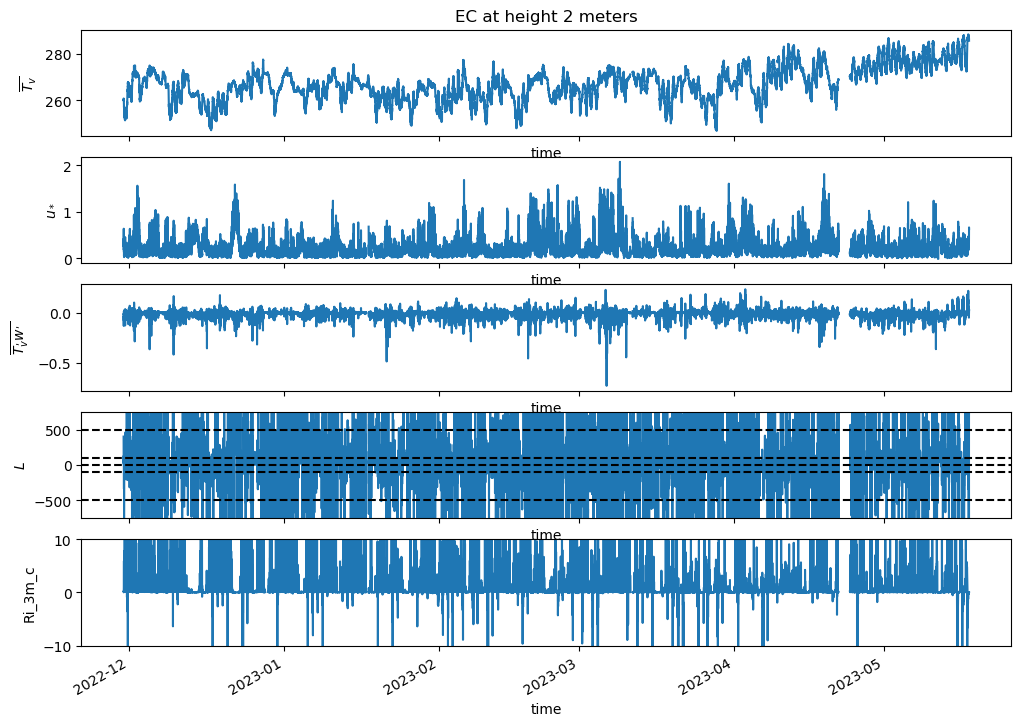

In [7]:
i = 2
fig, axes = plt.subplots(5, 1, figsize=(12,8), sharex=True)

(sos_ds[f'Tpotvirtual_{i}m_c']+273.15)

(sos_ds[f'Tvirtual_{i}m_c'] + 273.15).plot(ax = axes[0])
axes[0].set_ylabel(r'$\overline{T_v}$')

sos_ds[f'u*_{i}m_c'].plot(ax = axes[1])
axes[1].set_ylabel(r'$u_*$')

sos_ds[f'w_tc__{i}m_c'].plot(ax = axes[2])
axes[2].set_ylabel(r'$\overline{T_v^, w^,}$')

sos_ds[f'L_{i}m_c'].plot(ax = axes[3])
axes[3].axhline(-500, color='k', linestyle='--')
axes[3].axhline(-100, color='k', linestyle='--')
axes[3].axhline(0, color='k', linestyle='--')
axes[3].axhline(100, color='k', linestyle='--')
axes[3].axhline(500, color='k', linestyle='--')
axes[3].set_ylim(-750,750)
axes[3].set_ylabel(r'$L$')

axes[0].set_title(f"EC at height {i} meters")

sos_ds[f'Ri_3m_c'].plot(ax = axes[4])
axes[4].set_ylim(-10,10)

# Get Tidy Dataset

In [8]:
tidy_df = tidy.get_tidy_dataset(sos_ds, list(sos_ds.data_vars))

In [9]:
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, pytz.timezone('US/Mountain'))

Which variables did not get a "measurement" name assigned?

In [10]:
variables_with_no_measurement = tidy_df[tidy_df.measurement.apply(lambda x: x is None)].variable.unique()
variables_with_no_measurement

array(['Tcase_in_9m_d', 'Tcase_out_9m_d', 'Rpile_out_9m_d',
       'Rpile_in_9m_d'], dtype=object)

# Calculate additional new variables

## Net LW and Net SW

In [11]:
## Add Net LW variable
net_lw_radiation_values = (
        tidy_df.query("variable == 'Rlw_in_9m_d'")['value'].values
        -
        tidy_df.query("variable == 'Rlw_out_9m_d'")['value'].values
    )
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    net_lw_radiation_values,
    'Rlw_net_9m_d',
    'longwave net radiation',
    9,
    'd'
)

## Add Net SW variable
net_sw_radiation_values = (
        tidy_df.query("variable == 'Rsw_in_9m_d'")['value'].values
        -
        tidy_df.query("variable == 'Rsw_out_9m_d'")['value'].values
    )
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    net_sw_radiation_values,
    'Rsw_net_9m_d',
    'shortwave net radiation',
    9,
    'd'
)

## Net Radiation

In [12]:
## Add Net Rad variable
net_radiation_values = (
    (
        tidy_df.query("variable == 'Rsw_in_9m_d'")['value'].values
        +
        tidy_df.query("variable == 'Rlw_in_9m_d'")['value'].values
    ) - (
        tidy_df.query("variable == 'Rsw_out_9m_d'")['value'].values
        +
        tidy_df.query("variable == 'Rlw_out_9m_d'")['value'].values
    )
)
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    net_radiation_values,
    'Rnet_9m_d',
    'net radiation',
    9,
    'd'
)

## Specific humidity

In [13]:
from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.units import units
import xarray as xr
import pint_xarray

for v in [
    'Tsurfmixingratio_c',
    'mixingratio_2m_c',
    'mixingratio_3m_c',
    'mixingratio_4m_c',
    'mixingratio_5m_c',
    'mixingratio_6m_c',
    'mixingratio_7m_c',
    'mixingratio_8m_c',
    'mixingratio_9m_c',
    'mixingratio_10m_c',
    'mixingratio_11m_c',
    'mixingratio_12m_c',
    'mixingratio_13m_c',
    'mixingratio_14m_c',
    'mixingratio_15m_c',
    'mixingratio_16m_c',
    'mixingratio_17m_c',
    'mixingratio_18m_c',
    'mixingratio_19m_c',
    'mixingratio_20m_c',
]:
    data = tidy_df[tidy_df.variable == v]
    specific_humidity_values = specific_humidity_from_mixing_ratio(
        xr.DataArray(data.value.values)*units('g/g')
    ).values
    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        specific_humidity_values,
        v.replace('mixingratio', 'specifichumidity'),
        'specific humidity',
        data.height.iloc[0],
        data.tower.iloc[0]
    )

## Mixing ratio gradient

In [14]:
new_variable = (
    tidy_df.query("variable == 'mixingratio_3m_c'").value.values
    - tidy_df.query("variable == 'Tsurfmixingratio_c'").value.values
) / 3

tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    new_variable,
    "q_gradient_3m_c",
    "mixing ratio gradient",
    3,
    'c'
)

## Rotated momentum flux variables

In [15]:
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'u_w__3m_c'")['value'].values**2 
        + tidy_df.query("variable == 'v_w__3m_c'")['value'].values**2
    ),
    'u_w_rot__3m_c',
    'u_w_rot__',
    3,
    'c'
)

tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'u_w__10m_c'")['value'].values**2 
        + tidy_df.query("variable == 'v_w__10m_c'")['value'].values**2
    ),
    'u_w_rot__10m_c',
    'u_w_rot__',
    10,
    'c'
)

tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'u_w__20m_c'")['value'].values**2 
        + tidy_df.query("variable == 'v_w__20m_c'")['value'].values**2
    ),
    'u_w_rot__20m_c',
    'u_w_rot__',
    20,
    'c'
)


# Calculate 30 Minute averages

In [16]:
tidy_df_30Min = pd.DataFrame(
    tidy_df.set_index('time').groupby(
        ['measurement', 'variable', 'height',  'tower']
    )['value'].resample('30Min').mean()
).reset_index()

# Calculate Penman-Monteith estimates of sublimation

In [17]:
import pyet 
from metpy.units import units
import pint_pandas

## Gather the data we need and make required conversaions

In [18]:
elev = 2863# from google earth

# Gather all variables we need
src = tidy_df[tidy_df.variable.isin([
    'T_3m_c',
    'spd_3m_c',
    'RH_3m_c',
    'Rnet_9m_d',
    'Rsw_in_9m_d',
    'T_3m_c'
])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
# Calculate means across 30min periods, mins and maxes for the required variables too
).reset_index().set_index('time').groupby(pd.Grouper(freq='30Min')).agg({
    'T_3m_c': ['mean', 'min', 'max'],
    'spd_3m_c': 'mean',
    'RH_3m_c': ['mean', 'min', 'max'],
    'Rnet_9m_d': 'mean',
    'Rsw_in_9m_d': 'mean',
})
# Remove the resulting hierarchical index
src.columns = ['_'.join(col).strip() for col in src.columns.values]
# Drop nans
# src = src.dropna()

# # # Convert W/m^2 to MJ/m^2/d
src['Rnet_9m_d_mean'] = pd.Series(src['Rnet_9m_d_mean'].values, dtype="pint[W/m^2]").pint.to('MJ/m^2/d').pint.magnitude.values
src['Rsw_in_9m_d_mean'] = pd.Series(src['Rsw_in_9m_d_mean'].values, dtype="pint[W/m^2]").pint.to('MJ/m^2/d').pint.magnitude.values
src['elevation'] = elev
src

,T_3m_c_mean,T_3m_c_min,T_3m_c_max,spd_3m_c_mean,RH_3m_c_mean,RH_3m_c_min,RH_3m_c_max,Rnet_9m_d_mean,Rsw_in_9m_d_mean,elevation
time,,,,,,,,,,
2022-11-29 17:00:00,-12.797492,-13.113847,-12.469777,3.323426,65.300786,58.585175,70.529083,-4.965172,-0.352467,2863
2022-11-29 17:30:00,-13.050861,-13.396750,-12.794490,4.556745,50.735089,47.638996,57.609478,-6.844837,-0.382727,2863
2022-11-29 18:00:00,-13.382802,-13.790894,-12.837063,3.731591,50.324087,46.751404,53.483006,-6.385244,-0.371056,2863
2022-11-29 18:30:00,-14.988197,-16.231266,-13.597954,1.838974,61.213638,53.338619,71.663116,-5.593020,-0.589699,2863
2022-11-29 19:00:00,-16.329076,-16.716507,-15.913083,1.354227,70.831669,68.301453,72.228645,-4.858094,-0.615169,2863
...,...,...,...,...,...,...,...,...,...,...
2023-05-17 15:30:00,13.910910,13.751372,14.084917,4.693956,30.443745,29.549730,31.339897,NaN,NaN,2863
2023-05-17 16:00:00,13.517461,13.063477,13.964637,4.374811,33.170502,31.718903,34.130718,NaN,NaN,2863
2023-05-17 16:30:00,13.357073,13.186260,13.732280,4.092707,32.588952,30.634781,33.968578,NaN,NaN,2863


## Calculate Penman-Monteith and Priestley-Taylor

In [19]:
# Both functions return units mm/day
sublimation_pm = pyet.pm(
        tmean = src['T_3m_c_mean'],
        wind = src['spd_3m_c_mean'],
        rh = src['RH_3m_c_mean'],
        rhmin = src['RH_3m_c_min'],
        rhmax = src['RH_3m_c_max'],
        tmin = src['T_3m_c_min'],
        tmax = src['T_3m_c_max'],
        rn = src['Rnet_9m_d_mean'],
        elevation = src['elevation'],
        clip_zero=False
    )
priestley_taylor = pyet.priestley_taylor(
        tmean = src['T_3m_c_mean'],
        rh = src['RH_3m_c_mean'],
        rhmin = src['RH_3m_c_min'],
        rhmax = src['RH_3m_c_max'],
        tmin = src['T_3m_c_min'],
        tmax = src['T_3m_c_max'],
        rn = src['Rnet_9m_d_mean'],
        elevation = src['elevation'],
        clip_zero=False
)

## Convert from mm/day to g/m^2/s

In [20]:
sublimation_pm = sublimation_pm/(86.4)
priestley_taylor = priestley_taylor/(86.4)

## Add to tidy df

In [21]:
tidy_df_30Min = tidy.tidy_df_add_variable(
    tidy_df_30Min,
    sublimation_pm.values,
    'w_h2o__predicted_penmanmonteith_3m_c',
    'w_h2o_',
    3,
    'c'
)

tidy_df_30Min = tidy.tidy_df_add_variable(
    tidy_df_30Min,
    priestley_taylor.values,
    'w_h2o__predicted_priestleytaylor_3m_c',
    'w_h2o_',
    3,
    'c'
)

# Calculate turbulent fluxes with MOST

In [22]:
import pint_xarray
from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.units import units

Prepare the input data we need

In [23]:
# EXTRACT VARIABLES
VARIABLES = [
    ## Input Variables
    'spd_3m_c',
    'Tpot_3m_c',
    'Tsurfpot_c',
    'airdensity_3m_c',
    'mixingratio_3m_c',
    'Tsurfmixingratio_c',
    'T_3m_c',
    ## Measurement Variables
    'w_h2o__3m_c',
    'w_tc__3m_c',
    'u*_3m_c',
    'Ri_3m_c',
]
print([ v for v in tidy_df_30Min.variable.unique() if v in VARIABLES ])

# CREATE WIDE DATAFRAME
variables_df = tidy_df_30Min[tidy_df_30Min.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

# MAKE CONVERSIONS
# convert from ˚C to K
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['Tpot_3m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tsurfpot_c'] = variables_df['Tsurfpot_c'] + 273.15
# comes in units of g/g
variables_df['specifichumidity_3m_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_3m_c'])*units('g/g')
).pint.to('g/kg').values
# comes in units of g/g,  solution requires it in units of g/kg
variables_df['specifichumidity_surface_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['Tsurfmixingratio_c'])*units('g/g')
).pint.to('g/kg').values

# CREATE MEASUREMENT HEIGHT VARIABLES
variables_df['measurement_height'] = 3

['airdensity_3m_c', 'Tsurfmixingratio_c', 'mixingratio_3m_c', 'Tpot_3m_c', 'Ri_3m_c', 'u*_3m_c', 'Tsurfpot_c', 'T_3m_c', 'w_h2o__3m_c', 'w_tc__3m_c', 'spd_3m_c']


## My Solution

In [24]:
import sys
sys.path.append('../paper1/')
from most import MOST, StabilityFunctionBrutsaert1982

most_config_dict = {
    0.0001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.0001),
    0.0005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.0005),
    0.001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.001),
    0.005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.005),
}

for z0, this_most in most_config_dict.items():
    L_solutions, u_friction_solutions, H_solutions, E_solutions = this_most.solve(
        variables_df['spd_3m_c'],
        variables_df['Tpot_3m_c'],
        variables_df['Tsurfpot_c'],
        variables_df['airdensity_3m_c'],
        variables_df['specifichumidity_3m_c'],
        variables_df['specifichumidity_surface_c'],
        variables_df['T_3m_c'],
        variables_df['measurement_height']
    )

    variables_df[f'L_solution_z0_{str(z0)}'] = L_solutions
    variables_df[f'u_friction_solution_z0_{str(z0)}'] = u_friction_solutions
    variables_df[f'H_solution_z0_{str(z0)}'] = H_solutions
    variables_df[f'E_solution_z0_{str(z0)}'] = E_solutions

    # convert from W/m^2 to ˚C*m/s
    variables_df[f'H_solution_z0_{str(z0)}'] = (variables_df[f'H_solution_z0_{str(z0)}']/(variables_df['airdensity_3m_c']*0.718*1000))

Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
Reached maximum iterations
R

Add nans for the model results where there are missing timesteps (As compared to the tidy dataset of measurements)

In [25]:
variables_df['time'] = pd.to_datetime(variables_df['time'])

variables_df = pd.merge(
    tidy_df_30Min.query("variable == 'w_h2o__3m_c'")[['time']],
    variables_df,
    on='time',
    how='outer'
)

# Add solutions to the tidy dataset

In [26]:
# OUR SOLUTIONS
for z0 in most_config_dict.keys():
    tidy_df_30Min = tidy.tidy_df_add_variable(
        tidy_df_30Min,  
        variables_df[f'L_solution_z0_{z0}'], 
        f'L predicted ({z0})',
        'Obukhov length', 
        3,
        'c'
    )

    tidy_df_30Min = tidy.tidy_df_add_variable(
        tidy_df_30Min, 
        variables_df[f'u_friction_solution_z0_{z0}'], 
        f'u*_3m_c predicted ({z0})',
        'shear velocity', 
        3,
        'c'
    )

    tidy_df_30Min = tidy.tidy_df_add_variable(
        tidy_df_30Min, 
        variables_df[f'H_solution_z0_{z0}'], 
        f'w_tc__3m_c predicted ({z0})',
        'w_tc_', 
        3,
        'c'
    )

    tidy_df_30Min = tidy.tidy_df_add_variable(
        tidy_df_30Min, 
        variables_df[f'E_solution_z0_{z0}'], 
        f'w_h2o__3m_c predicted ({z0})',
        'w_h2o_', 
        3,
        'c'
    )

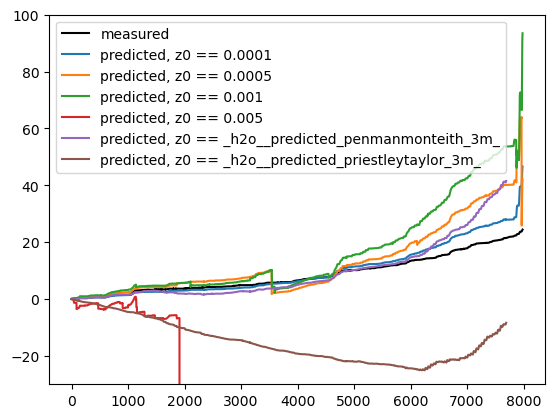

In [27]:
src = tidy_df_30Min[tidy_df_30Min.measurement == 'w_h2o_'].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()


src['w_h2o__5m_c'].cumsum().plot(color='black', label='measured')
for col in [c for c in src.columns if 'predicted' in c]:
    src[col].cumsum().plot(label = f"predicted, z0 == {col.split(' ')[-1][1:-1]}")
plt.ylim(-30,100)
plt.legend()

# Save dataset

In [28]:
ls -lah | grep parquet

-rw-rw-r--. 1 elilouis elilouis 349K Jul 26 16:12 precip_rate.parquet
-rw-rw-r--. 1 elilouis elilouis 172M Jun 21 22:13 tidy_df_20221130_20230509_noplanar_fit.parquet
-rw-rw-r--. 1 elilouis elilouis 195M Oct 17 13:02 tidy_df_20221130_20230517_noplanar_fit.parquet
-rw-rw-r--. 1 elilouis elilouis  29M Jun 21 22:13 tidy_df_30Min_20221130_20230509_noplanar_fit.parquet
-rw-rw-r--. 1 elilouis elilouis  34M Oct 17 13:02 tidy_df_30Min_20221130_20230517_noplanar_fit.parquet
-rw-rw-r--. 1 elilouis elilouis  26M May 23 21:41 tidy_df_30Min_20221201_20230501_noplanar_fit.parquet
-rw-rw-r--. 1 elilouis elilouis  18M May 18 19:33 tidy_df_30Min_20221201_20230501_planar_fit.parquet


In [29]:
if PLANAR_FIT:
    tidy_df_30Min.to_parquet(f'tidy_df_30Min_{start_date}_{end_date}_planar_fit.parquet', index=False)
    tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet', index=False)
else:
    tidy_df_30Min.to_parquet(f'tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet', index=False)
    tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet', index=False)

In [31]:
ls -lah | grep parquet

-rw-rw-r--. 1 elilouis elilouis 349K Jul 26 16:12 precip_rate.parquet
-rw-rw-r--. 1 elilouis elilouis 172M Jun 21 22:13 tidy_df_20221130_20230509_noplanar_fit.parquet
-rw-rw-r--. 1 elilouis elilouis 195M Oct 18 13:05 tidy_df_20221130_20230517_noplanar_fit.parquet
-rw-rw-r--. 1 elilouis elilouis  29M Jun 21 22:13 tidy_df_30Min_20221130_20230509_noplanar_fit.parquet
-rw-rw-r--. 1 elilouis elilouis  34M Oct 18 13:05 tidy_df_30Min_20221130_20230517_noplanar_fit.parquet
-rw-rw-r--. 1 elilouis elilouis  26M May 23 21:41 tidy_df_30Min_20221201_20230501_noplanar_fit.parquet
-rw-rw-r--. 1 elilouis elilouis  18M May 18 19:33 tidy_df_30Min_20221201_20230501_planar_fit.parquet


# Create disdrometer dataset with a "days since precip" variable

## Load disdrometer data

In [ ]:
import act

In [ ]:
# files = act.discovery.download_data(
#     os.getenv("ARM_USERNAME"),
#     os.getenv("ARM_TOKEN"),
#     'gucldM1.b1',
#     start_date,
#     end_date,
#     output='/data2/elilouis/sublimationofsnow/gucldM1.b1'
# )

import glob
files = glob.glob('/data2/elilouis/sublimationofsnow/gucldM1.b1/*.cdf')

In [ ]:
disdro_ds = xr.open_mfdataset(files)['precip_rate']

In [ ]:
disdro_ds

In [ ]:
precip_rate_ds = disdro_ds.sel(time=slice("2022-11-30", "2023-04-10")).resample(time='5Min').mean()
precip_rate_ds

In [ ]:
disdro_df = precip_rate_ds.to_dataframe().reset_index()
disdro_df = utils.modify_df_timezone(disdro_df, pytz.UTC, pytz.timezone('US/Mountain'))
disdro_df = disdro_df.set_index('time').loc[slice(start_date, end_date)]
# offset so the timestamp is in the middle, similar to SoS data
disdro_df.index = disdro_df.index + dt.timedelta(minutes=2, seconds=30)

In [ ]:
disdro_df

In [ ]:
disdro_df.to_parquet("precip_rate.parquet")

## Calculate "days since precip"

In [ ]:
disdro_daily_max_precip_date_df = disdro_df.set_index(
    "time"
)[['precip_rate']].resample(
    "1440Min"
).max().reset_index()

disdro_daily_mean_precip_date_df = disdro_df.set_index(
    "time"
)[['precip_rate']].resample(
    "1440Min"
).max().reset_index()

s = disdro_daily_max_precip_date_df.groupby(disdro_daily_max_precip_date_df['precip_rate'].ne(0).cumsum())['time'].transform('first')
disdro_daily_max_precip_date_df['days_since_precip'] = (disdro_daily_max_precip_date_df['time'] - s).dt.days

In [ ]:
daily_mean_precip_df = disdro_df.groupby("time")['precip_rate'].max()

daily_mean_precip_df = pd.DataFrame(daily_mean_precip_df.resample("1440Min").mean()*24/10) # resample to one day in cm/hr SWE

In [ ]:
disdro_daily_max_precip_date_df['daily_precip (cm)'] =  daily_mean_precip_df['precip_rate'].values

## Cache Downloaded Disdrometer data

In [ ]:
disdro_daily_max_precip_date_df.to_csv("disdro_daily_max_precip_date_df.csv")